<a href="https://colab.research.google.com/github/Intertangler/public_tools/blob/main/DATE_TITLE_experimental_designipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Experimental Design Tool

## Introduction
This notebook is a tool for facilitating experimental design through a Bayesian framework. It aids in structuring your experimental approach by encouraging the formulation of mutually exclusive hypotheses, considering potential results, and understanding how these results can influence the belief in one hypothesis over others. This tool is particularly useful in training researchers to think critically about the implications of their experimental design and data.

The Bayesian framework used here involves updating our beliefs (or hypotheses) in light of new evidence (or experimental results). This approach is grounded in Bayesian probability theory, where the probability of a hypothesis being true is updated as new data is observed.

## How to Use this Tool

### Step 1: Define Functions and Setup
The first cell contains essential Python functions for the tool. It includes functions for calculating entropy, creating probability bars for visualization, computing information gain, and generating reports and visualizations. **Run top cell first** to initialize these functions.

### Step 2: Fill in the Experiment Parameters
In the second cell, you will input the details of your experiment. This includes:

- **Experiment Title and Description**: Provide a general title and a brief description of your experiment.
- **Hypotheses (H1, H2, H3, ...)**: Define each hypothesis you want to test. These should be mutually exclusive and cover different aspects or theories related to your experiment.
- **Priors (P(H1), P(H2), P(H3), ...)**: Assign prior probabilities to each hypothesis based on your current belief or knowledge before observing new data.
- **Results (R1, R2, R3, ...)**: List possible results or outcomes you expect from the experiment.
- **Likelihoods**: Provide the likelihoods (P(R_i|H_j)) of observing each result given each hypothesis. This matrix should be structured such that each row corresponds to a hypothesis and each column to a result.
- **Descriptions**: Write detailed descriptions for each hypothesis and result to clarify their meanings.

### Step 3: Generate Report and Visualizations
After filling in the parameters, running the subsequent cells will generate a report and visualizations. The report will include:

- **Prior Probabilities**: Your initial beliefs about the hypotheses.
- **Likelihoods of Results**: How likely each result is under each hypothesis.
- **Posterior Probabilities**: Updated beliefs about the hypotheses after considering the potential results.
- **Information Gain**: How much each result is expected to inform us about the hypotheses.
- **Balance Score**: A measure of how evenly distributed the expected outcomes are across different results.

### Mathematical Definitions

- **Prior Probability $ P(H_j) $**: The probability of hypothesis $ H_j $ being true before considering new data.
  
- **Likelihood $ P(R_i|H_j) $**: The probability of observing result $ R_i $ given hypothesis $ H_j $ is true.

- **Posterior Probability $ P(H_j|R_i) $**: The updated probability of hypothesis $ H_j $ being true after observing result $ R_i $, calculated as $ P(H_j|R_i) = \frac{P(R_i|H_j) \cdot P(H_j)}{P(R_i)} $.

- **Total Probability of a Result $ P(R_i) $**: The probability of observing result $ R_i $, summed over all hypotheses. It is computed as $ P(R_i) = \sum_{j} P(R_i|H_j) \cdot P(H_j) $.




In [6]:
"""
RUN THIS CELL FIRST
defines functions, then move on to the next cell
"""

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def entropy(probabilities):
    probabilities = probabilities[probabilities > 0]
    return -np.sum(probabilities * np.log(probabilities))

def create_probability_bar(probability, bar_length=20):
    filled_length = int(round(probability * bar_length))
    empty_length = bar_length - filled_length
    filled_bar = '▓' * filled_length
    empty_bar = '░' * empty_length
    return filled_bar + empty_bar

def check_probability_matrix(matrix):
    if not np.allclose(matrix.sum(axis=1), 1):
        raise ValueError("The rows of the likelihood matrix must sum to 1.")

def information_gain_for_result(priors, likelihood_matrix, result_index):
    prior_entropy = entropy(priors)
    posterior_probs = likelihood_matrix[:, result_index] * priors / np.dot(likelihood_matrix[:, result_index], priors)
    posterior_entropy = entropy(posterior_probs)
    return prior_entropy - posterior_entropy

def expected_information_gain(priors, likelihood_matrix):
    check_probability_matrix(likelihood_matrix)
    prior_entropy = entropy(priors)
    weighted_posterior_entropies = []
    for i in range(likelihood_matrix.shape[1]):
        posterior_probs = likelihood_matrix[:, i] * priors / np.dot(likelihood_matrix[:, i], priors)
        posterior_entropy = entropy(posterior_probs)
        weighted_posterior_entropies.append(np.dot(likelihood_matrix[:, i], priors) * posterior_entropy)
    expected_posterior_entropy = sum(weighted_posterior_entropies)
    return prior_entropy - expected_posterior_entropy

def balance_score(likelihood_matrix, priors):
    likelihood_matrix_transposed = likelihood_matrix.T
    expected_result_probs = np.dot(likelihood_matrix_transposed, priors)
    return np.std(expected_result_probs)

def check_priors(priors):
    if not np.isclose(priors.sum(), 1):
        raise ValueError("The sum of the prior probabilities must be 1.")

def generate_report(experiment_title, experiment_description, hypotheses, priors, results, likelihood_matrix):
    check_priors(priors)
    check_probability_matrix(likelihood_matrix)

    # Prepare the report string
    report_string = f"===={experiment_title}: Bayesian Experimental Design Input Parameters==== \n"
    report_string += f"=====Experiment description:=====\n{experiment_description}\n"

    # Calculate EIG and balance score
    eig = expected_information_gain(priors, likelihood_matrix)
    balance = balance_score(likelihood_matrix, priors)

    # Include EIG and balance score in the report
    report_string += f"\n Expected Information Gain: {eig:.3f}\n"
    report_string += f" Balance Score: {balance:.3f}\n"

    # Hypotheses and Priors
    report_string += "\n=====Hypotheses and their Prior Probabilities:=====\n"
    for hypo in hypotheses:
        full_description = hypothesis_descriptions[hypo]
        prior = priors[hypotheses.index(hypo)]
        bar = create_probability_bar(prior)
        report_string += f"*{full_description} (Prior: {prior:.2f}): {bar}\n"

    # Result Likelihoods
    report_string += "\n=====Results and Their Likelihoods:=====\n"
    for result in results:
        full_description = result_descriptions[result]
        report_string += f"**{full_description}:\n"
        for hypo in hypotheses:
            likelihood = likelihood_matrix[hypotheses.index(hypo), results.index(result)]
            bar = create_probability_bar(likelihood)
            hypo_description = hypothesis_descriptions[hypo]
            report_string += f"***Likelihood given {hypo_description}: {likelihood:.2f} {bar}\n"

    # Posterior Report with Bayes' Theorem
    report_string += "\n====Posterior Report for Different Results====\n"
    for i, result in enumerate(results):
        info_gain = information_gain_for_result(priors, likelihood_matrix, i)
        report_string += f"\n*If Result {result} Occurs (Information Gain: {info_gain:.3f}):\n"
        for j, hypo in enumerate(hypotheses):
            updated_probability = likelihood_matrix[j, i] * priors[j] / np.dot(likelihood_matrix[:, i], priors)
            prior_bar = create_probability_bar(priors[j])
            posterior_bar = create_probability_bar(updated_probability)

            report_string += f"**Hypothesis {j+1} ({hypo}): "
            report_string += f"<math>P(H_{j+1}|R_{i+1}) = \\frac{{P(R_{i+1}|H_{j+1}) \\cdot P(H_{j+1})}}{{P(R_{i+1})}}</math>\n"
            report_string += f"***PRIORPROB: {prior_bar}\n"
            report_string += f"***POSTERIORPROB: {posterior_bar}\n"

    return report_string




def generate_visualization(hypotheses, priors, likelihood_matrix, results):
    G = nx.DiGraph()
    node_positions = {}
    node_labels = {}

    for i, hypo in enumerate(hypotheses):
        G.add_node(hypo, size=priors[i]*3000, color='cyan')
        node_positions[hypo] = (0, i * (len(results) + 1))
        node_labels[hypo] = hypo + "\n" + str(priors[i] * 100) + "%"

        for j, result in enumerate(results):
            node = f"{result}{i+1}"  # Node names include hypothesis index
            likelihood = likelihood_matrix[i][j]
            weighted_likelihood = priors[i] * likelihood
            G.add_node(node, size=weighted_likelihood * 3000, color='magenta')
            node_positions[node] = (1, i * (len(results) + 1) + j)
            node_labels[node] = node

    edge_labels = {}
    for i, hypo in enumerate(hypotheses):
        for j, result in enumerate(results):
            node = f"{result}{i+1}"
            likelihood = likelihood_matrix[i][j]
            G.add_edge(hypo, node, weight=likelihood)
            edge_labels[(hypo, node)] = f"{likelihood*100:.0f}%"

    plt.figure(figsize=(4, len(hypotheses)*len(results)))
    nx.draw_networkx_nodes(G, node_positions, node_size=[data['size'] for node, data in G.nodes(data=True)],
                          node_color=[data['color'] for node, data in G.nodes(data=True)])
    nx.draw_networkx_edges(G, node_positions, width=2)
    nx.draw_networkx_labels(G, node_positions, labels=node_labels)

    nx.draw_networkx_edge_labels(G, node_positions, edge_labels=edge_labels)
    for node, data in G.nodes(data=True):
        if node not in hypotheses:
            x, y = node_positions[node]
            plt.text(x+0.1, y, f"{data['size']/3000*100:.1f}%", horizontalalignment='left', verticalalignment='center')
    plt.axis('off')
    plt.show()


def calculate_and_draw_posterior_updates(hypotheses, priors, result_probabilities, result_name):

    observed_index = results.index(result_name)
    unnormalized_posteriors = [priors[i] * result_probabilities[i][observed_index] for i in range(len(hypotheses))]
    normalization_constant = sum(unnormalized_posteriors)
    posteriors = [p / normalization_constant for p in unnormalized_posteriors]
    G = nx.DiGraph()
    pos = {}
    node_labels = {}
    edge_labels = {}
    for i, (hypo, prior) in enumerate(zip(hypotheses, priors)):
        G.add_node(hypo, size=prior*3000, color='cyan')
        pos[hypo] = (0, -i)
        node_labels[hypo] = hypo + "\n" + str(prior * 100) + "%"
        result_node = f"{result_name}_{i}"
        G.add_node(result_node, size=posteriors[i]*3000, color='magenta')
        pos[result_node] = (2, -i)
        node_labels[result_node] = f"{result_name}_{i}"
        G.add_edge(hypo, result_node, weight=result_probabilities[i][observed_index])
        edge_labels[(hypo, result_node)] = f"{result_probabilities[i][observed_index]*100:.0f}%"

    plt.figure(figsize=(4, 4))
    nx.draw_networkx_nodes(G, pos, node_size=[data['size'] for node, data in G.nodes(data=True)],
                           node_color=[data['color'] for node, data in G.nodes(data=True)])
    nx.draw_networkx_edges(G, pos, width=2)
    nx.draw_networkx_labels(G, pos, labels=node_labels)
    for i, posterior in enumerate(posteriors):
        result_node = f"{result_name}_{i}"
        x, y = pos[result_node]
        plt.text(x+0.25, y, f"{posterior*100:.1f}%", fontsize=10, verticalalignment='center', horizontalalignment='left')

    plt.axis('off')
    plt.show()


## example input parameters

====Example Experiment Title: Bayesian Experimental Design Input Parameters==== 
=====Experiment description:=====
This is an example experiment description.

 Expected Information Gain: 0.109
 Balance Score: 0.056

=====Hypotheses and their Prior Probabilities:=====
*Hypothesis 1 description (Prior: 0.30): ▓▓▓▓▓▓░░░░░░░░░░░░░░
*Hypothesis 2 description (Prior: 0.50): ▓▓▓▓▓▓▓▓▓▓░░░░░░░░░░
*Hypothesis 3 description (Prior: 0.20): ▓▓▓▓░░░░░░░░░░░░░░░░

=====Results and Their Likelihoods:=====
**Result A description:
***Likelihood given Hypothesis 1 description: 0.50 ▓▓▓▓▓▓▓▓▓▓░░░░░░░░░░
***Likelihood given Hypothesis 2 description: 0.20 ▓▓▓▓░░░░░░░░░░░░░░░░
***Likelihood given Hypothesis 3 description: 0.30 ▓▓▓▓▓▓░░░░░░░░░░░░░░
**Result B description:
***Likelihood given Hypothesis 1 description: 0.40 ▓▓▓▓▓▓▓▓░░░░░░░░░░░░
***Likelihood given Hypothesis 2 description: 0.20 ▓▓▓▓░░░░░░░░░░░░░░░░
***Likelihood given Hypothesis 3 description: 0.30 ▓▓▓▓▓▓░░░░░░░░░░░░░░
**Result C description:


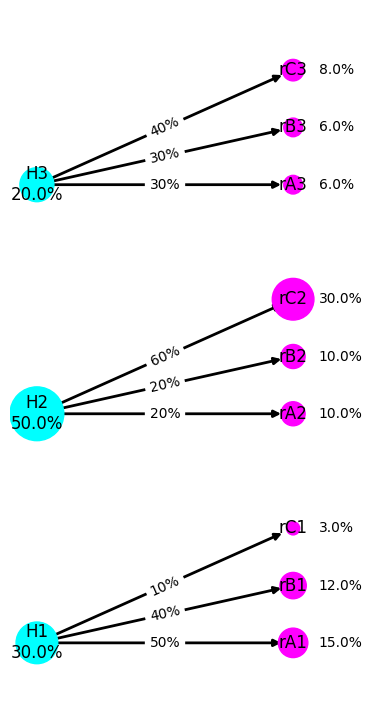

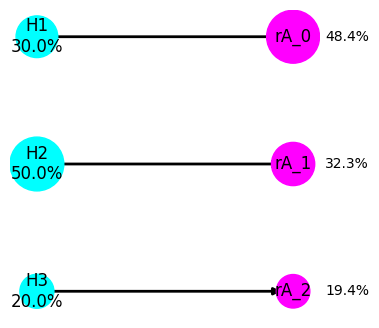

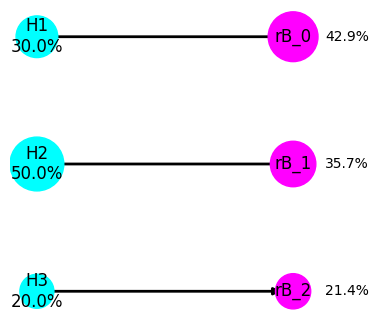

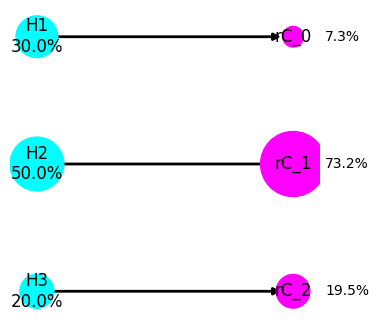

In [10]:
# parameters
experiment_title = "Example Experiment Title"
experiment_description = "This is an example experiment description."
hypotheses = ["H1", "H2", "H3"]
priors = np.array([0.3, 0.5, 0.2]) # add as many as you can think of, must sum to 1
results = ["rA", "rB", "rC"]

# Updated probabilities (likelihoods) for results given hypotheses
likelihood_matrix = np.array([
    [0.5, 0.4, 0.1],  # Likelihoods for H1 - rows of this matrix must sum to 1
    [0.2, 0.2, 0.6],  # Likelihoods for H2
    [0.3, 0.3, 0.4]   # Likelihoods for H3, add more as relevant
])

# Descriptions for hypotheses and results
hypothesis_descriptions = {
    "H1": "Hypothesis 1 description",
    "H2": "Hypothesis 2 description",
    "H3": "Hypothesis 3 description"
}

result_descriptions = {
    "rA": "Result A description",
    "rB": "Result B description",
    "rC": "Result C description"
}

# Generate the report
report = generate_report(experiment_title, experiment_description, hypotheses, priors, results, likelihood_matrix)
print(report)

# Visualization and Posterior Updates
generate_visualization(hypotheses, priors, likelihood_matrix, results)
for result in results:
    calculate_and_draw_posterior_updates(hypotheses, priors, likelihood_matrix, result)


====Mechanistic Study of Oligonucleotide Deposition via Aspiration: Bayesian Experimental Design Input Parameters==== 
=====Experiment description:=====
Exploring various physical and chemical mechanisms by which aspiration aids in the uniform deposition of oligonucleotides on an activated surface. The addition of surfactant is used as a variable to test these mechanisms.

 Expected Information Gain: 0.034
 Balance Score: 0.025

=====Hypotheses and their Prior Probabilities:=====
*Aspiration creates Marangoni flows due to non-uniform evaporation, aiding uniform deposition (Prior: 0.10): ▓▓░░░░░░░░░░░░░░░░░░
*Aspiration mechanically stabilizes the oligo layer during deposition (Prior: 0.05): ▓░░░░░░░░░░░░░░░░░░░
*Pressure differentials from aspiration enhance uniform oligo distribution (Prior: 0.05): ▓░░░░░░░░░░░░░░░░░░░
*Aspiration leads to a reverse coffee-ring effect with close-packed particles at the center (Prior: 0.40): ▓▓▓▓▓▓▓▓░░░░░░░░░░░░
*Rapid drying from thin layers formed by

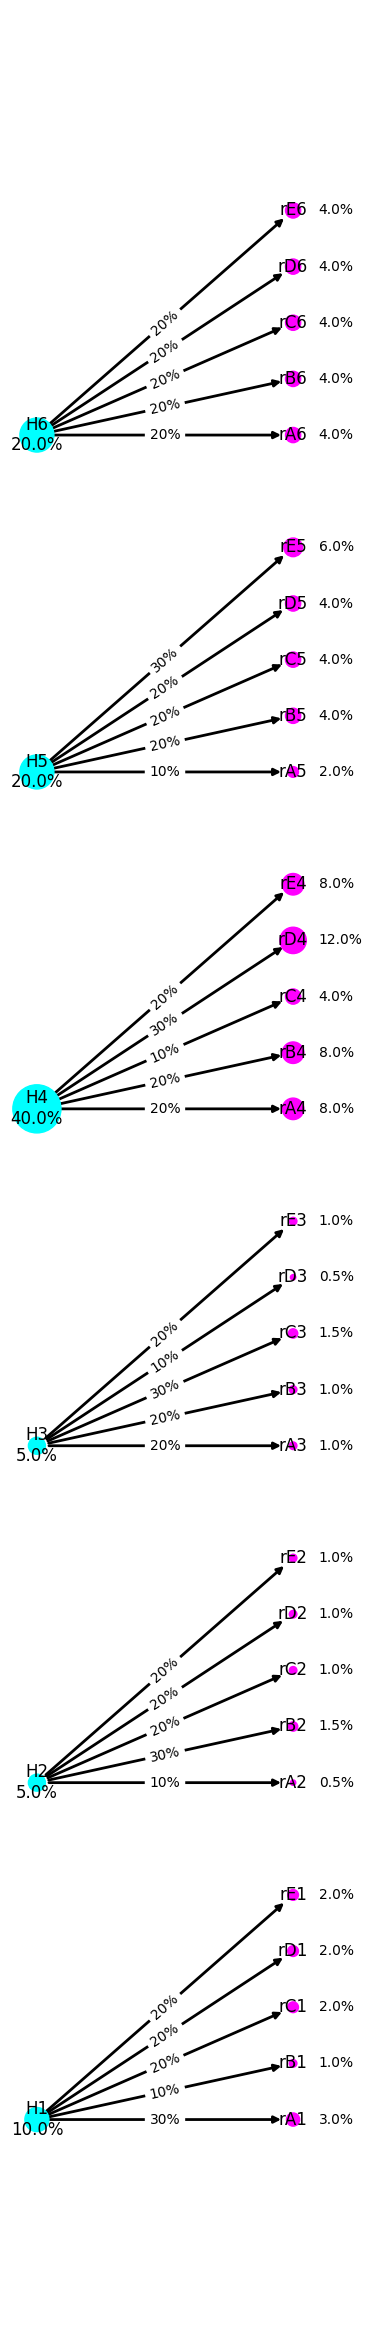

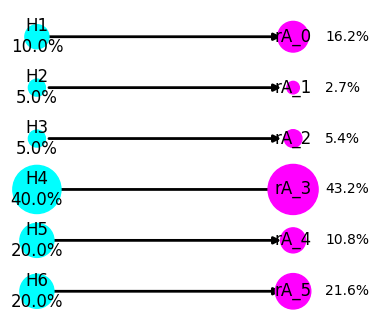

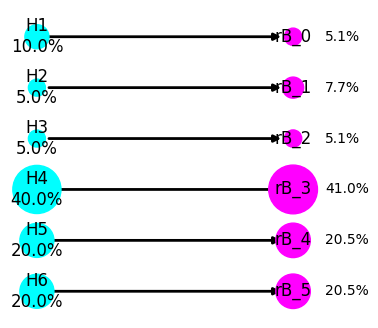

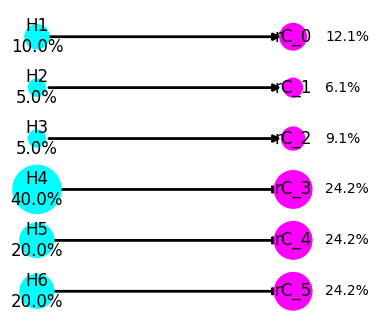

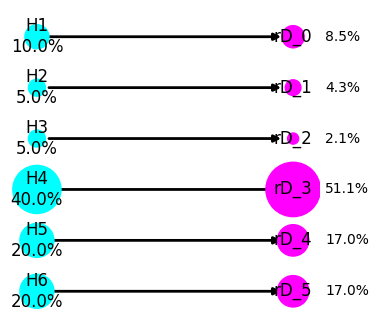

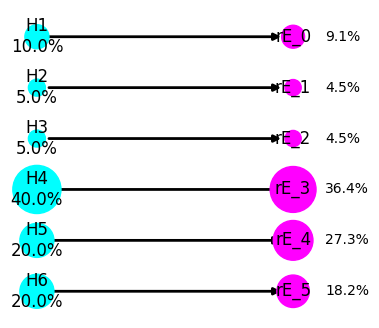

In [16]:
# parameters
experiment_title = "Mechanistic Study of Oligonucleotide Deposition via Aspiration"
experiment_description = (
    "Exploring various physical and chemical mechanisms by which aspiration aids in the uniform deposition "
    "of oligonucleotides on an activated surface. The addition of surfactant is used as a variable to test "
    "these mechanisms."
)

# Expanded set of mutually exclusive hypotheses
hypotheses = ["H1", "H2", "H3", "H4", "H5", "H6"]
priors = np.array([.1,.05,.05,.4,.2,.2]) # Equal priors for six hypotheses

# Possible results
results = ["rA", "rB", "rC", "rD", "rE"]

# Likelihoods for results given hypotheses
likelihood_matrix = np.array([
    [0.1, 0.1, 0.1, 0.2, 0.5],  # Likelihoods for H1
    [0.1, 0.3, 0.2, 0.2, 0.2],  # Likelihoods for H2
    [0.2, 0.2, 0.3, 0.1, 0.2],  # Likelihoods for H3
    [0.2, 0.2, 0.1, 0.3, 0.2],  # Likelihoods for H4
    [0.1, 0.2, 0.2, 0.2, 0.3],  # Likelihoods for H5
    [0.2, 0.2, 0.2, 0.2, 0.2]   # Likelihoods for H6
])

# Descriptions for hypotheses and results
hypothesis_descriptions = {
    "H1": "Aspiration creates Marangoni flows due to non-uniform evaporation, aiding uniform deposition",
    "H2": "Aspiration mechanically stabilizes the oligo layer during deposition",
    "H3": "Pressure differentials from aspiration enhance uniform oligo distribution",
    "H4": "Aspiration leads to a reverse coffee-ring effect with close-packed particles at the center",
    "H5": "Rapid drying from thin layers formed by aspiration results in uniform deposition",
    "H6": "Semi-dry conditions or high reactant concentrations from aspiration improve reaction outcomes"
}

result_descriptions = {
    "rA": "Uniform layer formation",
    "rB": "Non-uniform layer formation",
    "rC": "Enhanced deposition efficiency",
    "rD": "Distinct close-packed area formation",
    "rE": "No significant change"
}

# Generate the report
report = generate_report(experiment_title, experiment_description, hypotheses, priors, results, likelihood_matrix)
print(report)

# Visualization and Posterior Updates
generate_visualization(hypotheses, priors, likelihood_matrix, results)
for result in results:
    calculate_and_draw_posterior_updates(hypotheses, priors, likelihood_matrix, result)
